In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

class MoannaDataset(Dataset):
    def __init__(self, data_file, label_file):
        self.data = pd.read_csv(data_file, sep=',', header=0, index_col=0).values
        self.label = pd.read_csv(label_file, header=0, index_col=0).values[:,1]
        self.data = torch.from_numpy(self.data).float().to(device)
        self.label = self.label.astype(int)
        self.label = torch.from_numpy(self.label).long().to(device)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]


class MoannaModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MoannaModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        # self.t = nn.Tanh()
        self.dropout = nn.Dropout(dropout)
        # self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # self.relu1 = nn.ReLU()
        # self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        # out = self.batchnorm(out)
        out = self.relu(out)
        # out = self.t(out)
        out = self.dropout(out)
        # out = self.fc3(out)
        # out = self.relu1(out)
        # out = self.dropout1(out)
        out = self.fc2(out)
        return out

In [2]:

data_file = '/home/intern/WarmUpProject/p-tcga_binary_mutation.csv'
label_file = '/home/intern/WarmUpProject/pp-TCGA-clinical.csv'

dataset = MoannaDataset(data_file, label_file)



In [54]:
batch_size = 256


In [55]:
idx = torch.randperm(len(dataset))

split_point = int(0.7 * len(idx))

train_idx = list(idx[:split_point])
test_idx = list(idx[split_point:])

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 


In [56]:
len(train_dataset)

7028

In [57]:
train_dataset[7000][0]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [58]:
len(train_dataset[0][0])

13322

In [59]:
def k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device, shuffle=True):
    
    n_samples = len(train_dataset)
    fold_size = n_samples // k
    indices = np.random.permutation(n_samples)

    Model = []
    Train_acc = []
    Val_acc = []
    Test_acc = []
    
    for i in range(k):
        print(f"Processing fold {i+1}/{k}...")
        
        start = i * fold_size
        end = (i + 1) * fold_size
        
        traintrain_indices = list(np.concatenate([indices[:start], indices[end:]]))
        trainval_indices = list(indices[start:end])
        
        # Create data loaders for training and validation
        traintrain_dataset = Subset(train_dataset, traintrain_indices)
        trainval_dataset = Subset(train_dataset, trainval_indices)
        traintrain_loader = DataLoader(traintrain_dataset, batch_size=batch_size, shuffle=shuffle)
        trainval_loader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=False)    
        
        # Hyperparameters
        # learning_rate = 0.1
        # hidden_dim = 512

        # Initialize model and transfer to GPU
        model = MoannaModel(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        
        # Train the model
        train_losses = []
        train_accs = []
        val_accs = []
        test_accs = []
        
        for epoch in range(num_epochs):
            # Train
            model.train()
            train_loss = 0.0
            train_acc = 0.0
            for j, (inputs, labels) in enumerate(traintrain_loader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

            train_loss /= len(traintrain_loader)
            train_acc /= len(traintrain_loader)
            train_losses.append(train_loss)
            train_accs.append(train_acc)

            # Validate
            model.eval()
            val_acc = 0.0
            with torch.no_grad():
                for inputs, labels in trainval_loader:
                    outputs = model(inputs)
                    val_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                val_acc /= len(trainval_loader)
                val_accs.append(val_acc)

            # # Check if this is the best model so far
            # if val_acc > best_accuracy:
            #     best_accuracy = val_acc
            #     best_model = model.__class__(train_dataset.data.shape[1], hidden_dim, 33).to(device)
            #     best_model.load_state_dict(model.state_dict())
                
            # Test
            model.eval()
            test_acc = 0.0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())
                test_acc /= len(test_loader)
                test_accs.append(test_acc)
                
            print(f"Fold {i+1}/{k}, Epoch {epoch+1}: Train Loss={train_loss:.4f}, "
                  f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")
            
        MModel = model.__class__(len(train_dataset[0][0]), hidden_dim, 33).to(device)
        MModel.load_state_dict(model.state_dict())
        Model.append(MModel)
        
        Train_acc.append(train_accs[-1])
        Val_acc.append(val_accs[-1])
        Test_acc.append(test_accs[-1])
        
        # Plot loss and accuracy for this fold
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.legend()
        plt.title(f"Fold {i+1} Loss")

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(val_accs, label='Val Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.legend()
        plt.title(f"Fold {i+1} Accuracy")
        plt.show()

    return Model, Train_acc, Val_acc, Test_acc

Processing fold 1/5...
Fold 1/5, Epoch 1: Train Loss=3.4722, Train Acc=0.0862, Val Acc=0.1170, Test Acc=0.1144
Fold 1/5, Epoch 2: Train Loss=3.4022, Train Acc=0.1195, Val Acc=0.1320, Test Acc=0.1344
Fold 1/5, Epoch 3: Train Loss=3.3273, Train Acc=0.1394, Val Acc=0.1438, Test Acc=0.1455
Fold 1/5, Epoch 4: Train Loss=3.2588, Train Acc=0.1499, Val Acc=0.1588, Test Acc=0.1614
Fold 1/5, Epoch 5: Train Loss=3.1916, Train Acc=0.1620, Val Acc=0.1673, Test Acc=0.1779
Fold 1/5, Epoch 6: Train Loss=3.1350, Train Acc=0.1752, Val Acc=0.1699, Test Acc=0.1796
Fold 1/5, Epoch 7: Train Loss=3.0840, Train Acc=0.1802, Val Acc=0.1745, Test Acc=0.1861
Fold 1/5, Epoch 8: Train Loss=3.0322, Train Acc=0.1912, Val Acc=0.1824, Test Acc=0.1942
Fold 1/5, Epoch 9: Train Loss=2.9860, Train Acc=0.2013, Val Acc=0.1869, Test Acc=0.1946
Fold 1/5, Epoch 10: Train Loss=2.9409, Train Acc=0.2077, Val Acc=0.1986, Test Acc=0.2087
Fold 1/5, Epoch 11: Train Loss=2.8885, Train Acc=0.2257, Val Acc=0.2064, Test Acc=0.2128
Fold 1/

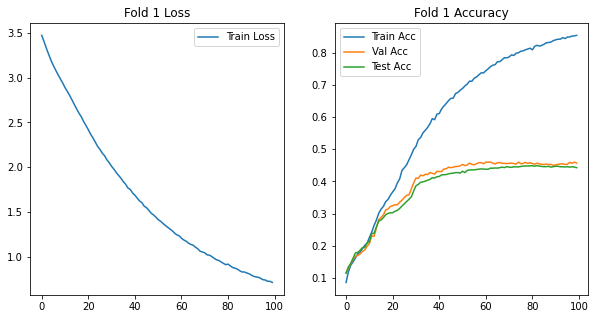

Processing fold 2/5...
Fold 2/5, Epoch 1: Train Loss=3.4740, Train Acc=0.0770, Val Acc=0.1432, Test Acc=0.1312
Fold 2/5, Epoch 2: Train Loss=3.4035, Train Acc=0.1280, Val Acc=0.1543, Test Acc=0.1436
Fold 2/5, Epoch 3: Train Loss=3.3372, Train Acc=0.1425, Val Acc=0.1648, Test Acc=0.1566
Fold 2/5, Epoch 4: Train Loss=3.2633, Train Acc=0.1560, Val Acc=0.1726, Test Acc=0.1662
Fold 2/5, Epoch 5: Train Loss=3.1947, Train Acc=0.1629, Val Acc=0.1916, Test Acc=0.1853
Fold 2/5, Epoch 6: Train Loss=3.1482, Train Acc=0.1756, Val Acc=0.1876, Test Acc=0.1846
Fold 2/5, Epoch 7: Train Loss=3.0938, Train Acc=0.1837, Val Acc=0.1948, Test Acc=0.1947
Fold 2/5, Epoch 8: Train Loss=3.0443, Train Acc=0.1963, Val Acc=0.2001, Test Acc=0.1989
Fold 2/5, Epoch 9: Train Loss=2.9927, Train Acc=0.2083, Val Acc=0.2080, Test Acc=0.2032
Fold 2/5, Epoch 10: Train Loss=2.9458, Train Acc=0.2212, Val Acc=0.2152, Test Acc=0.2051
Fold 2/5, Epoch 11: Train Loss=2.9083, Train Acc=0.2352, Val Acc=0.2184, Test Acc=0.2115
Fold 2/

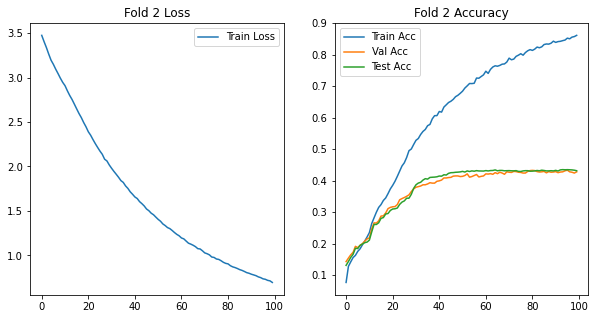

Processing fold 3/5...
Fold 3/5, Epoch 1: Train Loss=3.4714, Train Acc=0.0899, Val Acc=0.1227, Test Acc=0.1364
Fold 3/5, Epoch 2: Train Loss=3.3971, Train Acc=0.1354, Val Acc=0.1353, Test Acc=0.1438
Fold 3/5, Epoch 3: Train Loss=3.3171, Train Acc=0.1458, Val Acc=0.1359, Test Acc=0.1477
Fold 3/5, Epoch 4: Train Loss=3.2490, Train Acc=0.1556, Val Acc=0.1471, Test Acc=0.1579
Fold 3/5, Epoch 5: Train Loss=3.1825, Train Acc=0.1695, Val Acc=0.1588, Test Acc=0.1724
Fold 3/5, Epoch 6: Train Loss=3.1264, Train Acc=0.1821, Val Acc=0.1582, Test Acc=0.1777
Fold 3/5, Epoch 7: Train Loss=3.0738, Train Acc=0.1898, Val Acc=0.1692, Test Acc=0.1870
Fold 3/5, Epoch 8: Train Loss=3.0309, Train Acc=0.2019, Val Acc=0.1770, Test Acc=0.1958
Fold 3/5, Epoch 9: Train Loss=2.9780, Train Acc=0.2105, Val Acc=0.1921, Test Acc=0.2107
Fold 3/5, Epoch 10: Train Loss=2.9227, Train Acc=0.2158, Val Acc=0.1927, Test Acc=0.2127
Fold 3/5, Epoch 11: Train Loss=2.8800, Train Acc=0.2375, Val Acc=0.2013, Test Acc=0.2227
Fold 3/

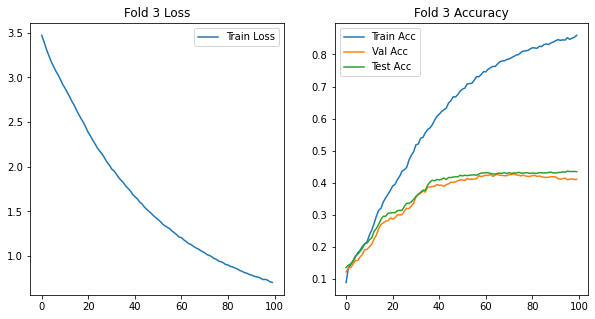

Processing fold 4/5...
Fold 4/5, Epoch 1: Train Loss=3.4785, Train Acc=0.0454, Val Acc=0.0641, Test Acc=0.0621
Fold 4/5, Epoch 2: Train Loss=3.4113, Train Acc=0.1193, Val Acc=0.1446, Test Acc=0.1478
Fold 4/5, Epoch 3: Train Loss=3.3389, Train Acc=0.1485, Val Acc=0.1460, Test Acc=0.1499
Fold 4/5, Epoch 4: Train Loss=3.2645, Train Acc=0.1558, Val Acc=0.1577, Test Acc=0.1644
Fold 4/5, Epoch 5: Train Loss=3.2018, Train Acc=0.1676, Val Acc=0.1636, Test Acc=0.1711
Fold 4/5, Epoch 6: Train Loss=3.1494, Train Acc=0.1714, Val Acc=0.1721, Test Acc=0.1816
Fold 4/5, Epoch 7: Train Loss=3.0966, Train Acc=0.1745, Val Acc=0.1773, Test Acc=0.1843
Fold 4/5, Epoch 8: Train Loss=3.0480, Train Acc=0.1897, Val Acc=0.1812, Test Acc=0.1897
Fold 4/5, Epoch 9: Train Loss=3.0003, Train Acc=0.2039, Val Acc=0.1943, Test Acc=0.2004
Fold 4/5, Epoch 10: Train Loss=2.9500, Train Acc=0.2142, Val Acc=0.1989, Test Acc=0.2009
Fold 4/5, Epoch 11: Train Loss=2.9084, Train Acc=0.2262, Val Acc=0.2120, Test Acc=0.2066
Fold 4/

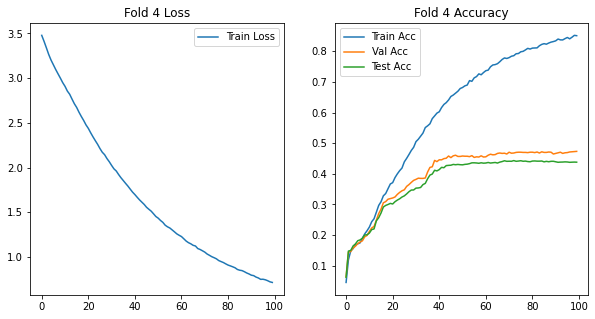

Processing fold 5/5...
Fold 5/5, Epoch 1: Train Loss=3.4693, Train Acc=0.0543, Val Acc=0.0601, Test Acc=0.0619
Fold 5/5, Epoch 2: Train Loss=3.3962, Train Acc=0.0973, Val Acc=0.1280, Test Acc=0.1396
Fold 5/5, Epoch 3: Train Loss=3.3251, Train Acc=0.1476, Val Acc=0.1425, Test Acc=0.1488
Fold 5/5, Epoch 4: Train Loss=3.2554, Train Acc=0.1622, Val Acc=0.1535, Test Acc=0.1683
Fold 5/5, Epoch 5: Train Loss=3.1973, Train Acc=0.1665, Val Acc=0.1575, Test Acc=0.1690
Fold 5/5, Epoch 6: Train Loss=3.1427, Train Acc=0.1745, Val Acc=0.1607, Test Acc=0.1783
Fold 5/5, Epoch 7: Train Loss=3.0968, Train Acc=0.1768, Val Acc=0.1686, Test Acc=0.1820
Fold 5/5, Epoch 8: Train Loss=3.0425, Train Acc=0.1924, Val Acc=0.1633, Test Acc=0.1823
Fold 5/5, Epoch 9: Train Loss=2.9957, Train Acc=0.1943, Val Acc=0.1784, Test Acc=0.1948
Fold 5/5, Epoch 10: Train Loss=2.9525, Train Acc=0.2151, Val Acc=0.1850, Test Acc=0.2000
Fold 5/5, Epoch 11: Train Loss=2.9003, Train Acc=0.2284, Val Acc=0.1935, Test Acc=0.2069
Fold 5/

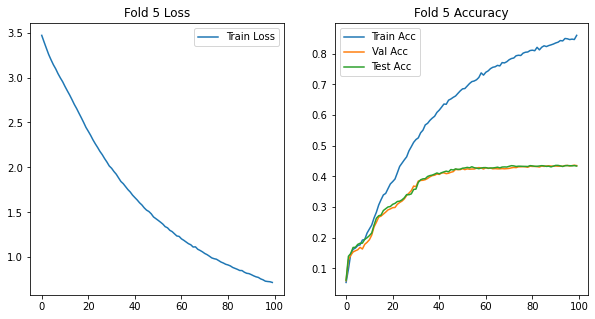

In [60]:
num_epochs = 100
k = 5
learning_rate = 0.1
hidden_dim = 128

Model, Train_acc, Val_acc, Test_acc = k_fold_cross_validation(train_dataset, test_loader, k, num_epochs, batch_size, learning_rate, hidden_dim, device=device, shuffle=True)

In [61]:
Model

[MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=128, out_features=33, bias=True)
 ),
 MoannaModel(
   (fc1): Linear(in_features=13322, out_features=128, bias=True)
   (relu): ReLU()
   (dropout): Dropout(p=0.5, inplace=False)
   (fc2): Linear(in_features=12

In [62]:
Train_acc

[0.8539929437338977,
 0.8612339551895474,
 0.8594777960526315,
 0.8509421294166359,
 0.8597135800055207]

In [63]:
Val_acc

[0.456890625,
 0.42808854166666666,
 0.4110364583333333,
 0.4732604166666667,
 0.43515624999999997]

In [64]:
Test_acc

[0.4426290186125212,
 0.43159601046954316,
 0.4348165186125212,
 0.4379742359348562,
 0.43364497409052455]

In [65]:
TRAIN_acc = np.mean(Train_acc)
print(f"{TRAIN_acc:.4f}")

0.8571


In [66]:
VAL_acc = np.mean(Val_acc)
print(f"{VAL_acc:.4f}")

0.4409


In [67]:
TEST_acc = np.mean(Test_acc)
print(f"{TEST_acc:.4f}")

0.4361


In [68]:
def test_model(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_acc += accuracy_score(torch.argmax(outputs, dim=1).cpu(), labels.cpu())

        test_acc /= len(test_loader)

    print(f"Test Accuracy: {test_acc:.4f}")

In [69]:
for i in range(5):
    test_model(Model[i], test_loader)

Test Accuracy: 0.4426
Test Accuracy: 0.4316
Test Accuracy: 0.4348
Test Accuracy: 0.4380
Test Accuracy: 0.4336


In [70]:
for inputs, labels in train_loader:
    outputs = Model[1](inputs)
    print(torch.argmax(outputs, dim=1))
    print(labels)

tensor([ 4,  7, 16, 21, 13,  7, 13,  4, 25, 14, 21, 15, 14, 22,  2, 27, 27, 25,
        27, 27,  4, 27, 28, 15, 19, 16,  2, 15, 27, 29, 11, 24,  7, 25,  1, 29,
        16, 29, 21,  6, 14, 27, 29, 16,  1,  8, 24, 18, 11, 21, 16,  1, 22, 18,
        15, 27,  8,  1, 15, 19, 27,  1, 24, 18, 18, 15, 21, 13,  1, 21,  1, 18,
         0,  1, 29, 18,  1, 27, 27,  8,  1, 27, 15,  2, 21,  8, 16,  1, 22, 27,
        10, 21, 14,  1, 25,  1,  4, 27, 15, 10, 13, 15, 29,  7, 21,  1, 29, 10,
         0, 27, 14, 29, 16,  8, 27,  2, 13,  1, 23, 21, 28, 18, 18,  0,  7,  7,
         1, 14, 14,  1,  6, 27, 27, 25, 13,  0, 18, 27, 11, 15,  8, 29, 23, 13,
        18, 13,  1, 27, 11, 13, 18, 15, 27, 16, 29, 27,  1,  8,  0, 24, 16, 27,
        16, 27, 11, 29,  1, 21, 27, 16, 16, 27, 21,  2, 21,  7, 11, 27, 27, 27,
        16, 14, 24, 18,  4,  1,  0,  7, 19,  7, 11, 27,  1, 16, 29, 16, 13, 24,
        18, 13, 15, 15,  4,  8, 13,  8,  1, 21, 15,  8, 18,  0, 19,  1, 15,  0,
        10,  6, 24, 28, 16, 14, 10,  6, 